In [1]:
import zipfile
import re
import numpy as np
import pandas as pd
import pickle
from tqdm import tqdm
from pprint import pprint

from nltk.corpus import stopwords
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel


import spacy


import pyLDAvis
import pyLDAvis.gensim  
import matplotlib.pyplot as plt
%matplotlib inline


import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

c:\users\piotrwiercinski\appdata\local\programs\python\python36\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
pd.set_option('display.height', 1000)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
df = pd.read_csv(r'lda_data\downloaded_articles.csv')

In [4]:
df.drop_duplicates('articleID', inplace=True)

In [5]:
df.head()

,articleID,keywords,text
0,5adf6684068401528a2aa69b,"['offer', 'statement', 'cheerleading', 'suppor...",The N.F.L. has responded with a written statem...
1,5adf653f068401528a2aa697,"['likely', 'epa', 'studies', 'effect', 'policy...",WASHINGTON — The Environmental Protection Agen...
2,5adf4626068401528a2aa628,"['probably', 'frequently', 'mr', 'asked', 'din...","If I get a reservation, will eating at Noma ma..."
3,5adf40d2068401528a2aa619,"['iran', 'nuclear', 'constrain', 'mr', 'korea'...",WASHINGTON — President Trump signaled on Tuesd...
4,5adf3d64068401528a2aa60f,"['counts', 'women', 'murder', 'tuesdaythe', 'e...",TORONTO — The man identified as the van driver...


In [6]:
df.shape

(9292, 3)

In [7]:
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [8]:
data = df.text.values.tolist()

data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]  # removing emails
data = [re.sub('\s+', ' ', sent) for sent in data]  # removing new line characters
data = [re.sub("\'", "", sent) for sent in data]  # removing single quotes

In [9]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # tokenizing & removing punctuation

data_words = list(sent_to_words(data))

In [10]:
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100)  # building bigram model
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  # building trigram model
trigram_mod = gensim.models.phrases.Phraser(trigram)

c:\users\piotrwiercinski\appdata\local\programs\python\python36\lib\site-packages\gensim\models\phrases.py:494: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [11]:
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'ADV']):  # only consider nouns, adjectives and adverbs
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [12]:
data_words_nostops = remove_stopwords(data_words)  # removing stopwords
data_words_bigrams = make_bigrams(data_words_nostops)  # forming bigrams

nlp = spacy.load('en', disable=['parser', 'ner'])

data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'ADV'])  # lemmatize

In [13]:
id2word = corpora.Dictionary(data_lemmatized)  # define id: word dictionary

texts = data_lemmatized  # text corpus
corpus = [id2word.doc2bow(text) for text in texts]  # term document frequency

In [14]:
def compute_coherence_values(dictionary, corpus, texts, limit, start, step):
    coherence_values = []
    model_list = []
    for num_topics in tqdm(range(start, limit, step)):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, id2word=id2word, random_state=1, passes=10)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [15]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=20, limit=150, step=10)

 62%|████████████████████████████████████████████████▌                              | 8/13 [32:16<20:10, 242.02s/it]c:\users\piotrwiercinski\appdata\local\programs\python\python36\lib\site-packages\gensim\models\ldamodel.py:775: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)
100%|████████████████████████████████████████████████████████████████████████████| 13/13 [1:12:25<00:00, 334.28s/it]


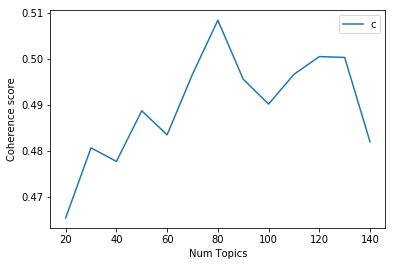

In [16]:
limit=150; start=20; step=10;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

80 topics seem optimal, the final model is trained on 30 passes due to the small amount of data (under 10k articles). <br>
Below it can be seen that increasing the number of passes to 30 indeed marginally improves the Coherence score to 0.52.

In [17]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,  # defining lda model
                                           id2word=id2word,
                                           num_topics=80, 
                                           random_state=1,
                                           passes=30,
                                           chunksize=2000)

In [18]:
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(18,
  '0.043*"white" + 0.018*"temperature" + 0.016*"population" + 0.015*"degree" + '
  '0.015*"hispanic" + 0.013*"census" + 0.013*"dental" + 0.013*"latino" + '
  '0.012*"baker" + 0.012*"harris"'),
 (44,
  '0.183*"city" + 0.055*"new_york" + 0.029*"street" + 0.023*"neighborhood" + '
  '0.021*"resident" + 0.019*"mayor" + 0.016*"store" + 0.014*"brooklyn" + '
  '0.012*"community" + 0.012*"marijuana"'),
 (14,
  '0.038*"flight" + 0.033*"plane" + 0.024*"air" + 0.019*"passenger" + '
  '0.018*"island" + 0.016*"pilot" + 0.013*"virus" + 0.013*"aircraft" + '
  '0.012*"ship" + 0.012*"helicopter"'),
 (62,
  '0.025*"people" + 0.011*"way" + 0.010*"many" + 0.010*"even" + 0.008*"good" + '
  '0.008*"thing" + 0.007*"right" + 0.006*"problem" + 0.006*"power" + '
  '0.005*"much"'),
 (57,
  '0.119*"sex" + 0.053*"teenager" + 0.035*"porn" + 0.033*"sexual" + '
  '0.017*"heel" + 0.015*"ed" + 0.015*"library" + 0.015*"wright" + '
  '0.014*"sexuality" + 0.014*"basement"'),
 (43,
  '0.050*"phone" + 0.030*"apple" + 0

In [19]:
print('\nPerplexity: ', lda_model.log_perplexity(corpus)) 
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -11.520226370072272

Coherence Score:  0.5149799585790206


The interface below 

In [20]:
pyLDAvis.enable_notebook()  # topic visualisation
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word, sort_topics=False)
vis

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
0       0.313223        1       1 -0.113723 -0.012093
1       0.376948        1       2 -0.116497 -0.019393
2       0.192412        1       3 -0.174154 -0.001856
3       0.332506        1       4 -0.109473  0.003043
4       1.593705        1       5  0.177786 -0.166627
5       0.237305        1       6 -0.146238  0.003867
6      12.926865        1       7  0.270676  0.177493
7       3.525536        1       8  0.232337 -0.145689
8       0.172744        1       9 -0.165867  0.002507
9       0.298279        1      10 -0.048940  0.009001
10      0.076269        1      11 -0.216242  0.004693
11      4.820416        1      12  0.267418 -0.104569
12      0.748584        1      13  0.044736 -0.194065
13      1.303086        1      14  0.076078  0.020392
14      0.490739        1      15 -0.063076  0.019364
15      0.375282        1      16 -0.113880 -0.008450
16      1.417634        1      17  0.142201  0.076050
17      1.403628        1      18  0.116850  0.047195
18      0.380443        1      19 -0.057212  0.007835
19      0.243410        1      20 -0.141864 -0.037347
20      0.237660        1      21 -0.156745 -0.006368
21      1.041740        1      22  0.115333  0.107596
22      0.324752        1      23 -0.125808  0.018721
23      1.116037        1      24  0.098248 -0.052517
24      0.309036        1      25 -0.124333 -0.003873
25      0.232958        1      26 -0.126697  0.043730
26      1.211817        1      27  0.140647  0.067585
27      1.559117        1      28  0.116024  0.182723
28      1.436497        1      29  0.132951  0.017045
29      0.281539        1      30 -0.140436  0.005882
30      0.175604        1      31 -0.130567  0.035478
31      0.442001        1      32 -0.057709 -0.042856
32      0.196736        1      33 -0.149773  0.020147
33      0.257600        1      34 -0.124238  0.001800
34      0.325957        1      35 -0.095187  0.045351
35      0.569602        1      36 -0.004387 -0.015943
36      0.131229        1      37 -0.189571 -0.001871
37      1.834103        1      38  0.139707 -0.164688
38      4.014935        1      39  0.282402  0.026911
39      0.280772        1      40 -0.134497 -0.000904
40      1.069022        1      41  0.055495  0.055030
41      0.381421        1      42 -0.063424  0.049839
42      4.476915        1      43  0.249784 -0.066948
43      0.357100        1      44 -0.105314 -0.001435
44      0.888144        1      45  0.075981  0.019806
45      2.006899        1      46  0.152338  0.038621
46      2.252289        1      47  0.161657  0.004826
47      0.763910        1      48 -0.024979  0.010786
48      0.493494        1      49 -0.058063  0.007712
49      0.344283        1      50 -0.092828  0.034208
50      3.789020        1      51  0.270853  0.001654
51      0.261445        1      52 -0.147978  0.002209
52      0.717820        1      53  0.013954  0.047234
53      0.589385        1      54 -0.029220 -0.021835
54      0.656056        1      55  0.039989  0.106884
55      1.395819        1      56  0.147776 -0.160916
56      0.440966        1      57 -0.070455 -0.061918
57      0.212191        1      58 -0.130811  0.030795
58      0.279884        1      59 -0.132039 -0.025485
59      0.755224        1      60 -0.040122  0.044522
60      0.213183        1      61 -0.158209 -0.016931
61      3.247152        1      62  0.229944  0.063675
62      8.187227        1      63  0.274561  0.062589
63      6.750520        1      64  0.245005  0.117601
64      0.238230        1      65 -0.140675  0.030169
65      0.528510        1      66 -0.018347 -0.106242
66      1.469946        1      67  0.126099 -0.066640
67      0.881495        1      68  0.031991 -0.239293
68      0.194850        1      69 -0.147999  0.001573
69      0.612041        1      70 -0.064724  0.013434
70      0.691299        1      71 -0.014961 -0.088795
71      0.520326        1  

In [21]:
df['corpus'] = corpus

In [22]:
df['lda_topics'] = df['corpus'].apply(lambda x:lda_model.get_document_topics(x))

In [23]:
all_topics = lda_model.show_topics(80)

In [24]:
topics_dict = {all_topics[i][0]: all_topics[i][1] for i in range(len(all_topics))}

In [25]:
df.head()

,articleID,keywords,text,corpus,lda_topics
0,5adf6684068401528a2aa69b,"['offer', 'statement', 'cheerleading', 'suppor...",The N.F.L. has responded with a written statem...,"[(0, 1), (1, 1), (2, 3), (3, 5), (4, 2), (5, 3...","[(17, 0.08008672), (21, 0.022569574), (26, 0.1..."
1,5adf653f068401528a2aa697,"['likely', 'epa', 'studies', 'effect', 'policy...",WASHINGTON — The Environmental Protection Agen...,"[(79, 1), (80, 1), (81, 1), (82, 5), (83, 1), ...","[(7, 0.0800965), (16, 0.44378182), (41, 0.0247..."
2,5adf4626068401528a2aa628,"['probably', 'frequently', 'mr', 'asked', 'din...","If I get a reservation, will eating at Noma ma...","[(7, 1), (60, 1), (97, 2), (119, 1), (120, 1),...","[(0, 0.018988285), (2, 0.121632785), (9, 0.018..."
3,5adf40d2068401528a2aa619,"['iran', 'nuclear', 'constrain', 'mr', 'korea'...",WASHINGTON — President Trump signaled on Tuesd...,"[(42, 1), (50, 1), (97, 4), (99, 2), (116, 1),...","[(0, 0.020230627), (7, 0.06410627), (11, 0.438..."
4,5adf3d64068401528a2aa60f,"['counts', 'women', 'murder', 'tuesdaythe', 'e...",TORONTO — The man identified as the van driver...,"[(38, 1), (76, 1), (97, 1), (113, 1), (116, 1)...","[(7, 0.086451806), (10, 0.021542551), (16, 0.0..."


In [26]:
all_articles = pd.read_csv(r'lda_data\all_articles.csv')

In [27]:
df = df.merge(all_articles, on='articleID', how='inner')

In [28]:
df.head()

,articleID,keywords_x,text,corpus,lda_topics,abstract,articleWordCount,byline,documentType,headline,keywords_y,multimedia,newDesk,printPage,pubDate,sectionName,snippet,source,typeOfMaterial,webURL
0,5adf6684068401528a2aa69b,"['offer', 'statement', 'cheerleading', 'suppor...",The N.F.L. has responded with a written statem...,"[(0, 1), (1, 1), (2, 3), (3, 5), (4, 2), (5, 3...","[(17, 0.08008672), (21, 0.022569574), (26, 0.1...",NaN,781,By JOHN BRANCH,article,Former N.F.L. Cheerleaders’ Settlement Offer: ...,"['Workplace Hazards and Violations', 'Football...",68,Sports,0,2018-04-24 17:16:49,Pro Football,"“I understand that they could meet with us, pa...",The New York Times,News,https://www.nytimes.com/2018/04/24/sports/foot...
1,5adf653f068401528a2aa697,"['likely', 'epa', 'studies', 'effect', 'policy...",WASHINGTON — The Environmental Protection Agen...,"[(79, 1), (80, 1), (81, 1), (82, 5), (83, 1), ...","[(7, 0.0800965), (16, 0.44378182), (41, 0.0247...",NaN,656,By LISA FRIEDMAN,article,E.P.A. to Unveil a New Rule. Its Effect: Less ...,"['Environmental Protection Agency', 'Pruitt, S...",68,Climate,0,2018-04-24 17:11:21,Unknown,The agency plans to publish a new regulation T...,The New York Times,News,https://www.nytimes.com/2018/04/24/climate/epa...
2,5adf4626068401528a2aa628,"['probably', 'frequently', 'mr', 'asked', 'din...","If I get a reservation, will eating at Noma ma...","[(7, 1), (60, 1), (97, 2), (119, 1), (120, 1),...","[(0, 0.018988285), (2, 0.121632785), (9, 0.018...",NaN,2427,By PETE WELLS,article,"The New Noma, Explained","['Restaurants', 'Noma (Copenhagen, Restaurant)...",66,Dining,0,2018-04-24 14:58:44,Unknown,What’s it like to eat at the second incarnatio...,The New York Times,News,https://www.nytimes.com/2018/04/24/dining/noma...
3,5adf40d2068401528a2aa619,"['iran', 'nuclear', 'constrain', 'mr', 'korea'...",WASHINGTON — President Trump signaled on Tuesd...,"[(42, 1), (50, 1), (97, 4), (99, 2), (116, 1),...","[(0, 0.020230627), (7, 0.06410627), (11, 0.438...",NaN,626,By JULIE HIRSCHFELD DAVIS and PETER BAKER,article,Unknown,"['Macron, Emmanuel (1977- )', 'Trump, Donald J...",68,Washington,0,2018-04-24 14:35:57,Europe,President Trump welcomed President Emmanuel Ma...,The New York Times,News,https://www.nytimes.com/2018/04/24/world/europ...
4,5adf3d64068401528a2aa60f,"['counts', 'women', 'murder', 'tuesdaythe', 'e...",TORONTO — The man identified as the van driver...,"[(38, 1), (76, 1), (97, 1), (113, 1), (116, 1)...","[(7, 0.086451806), (10, 0.021542551), (16, 0.0...",NaN,815,By IAN AUSTEN and DAN BILEFSKY,article,Unknown,"['Toronto, Ontario, Attack (April, 2018)', 'Mu...",68,Foreign,0,2018-04-24 14:21:21,Canada,"Alek Minassian, 25, a resident of Toronto’s Ri...",The New York Times,News,https://www.nytimes.com/2018/04/24/world/canad...


In [29]:
df.to_csv(r'lda_data\lda_topics_df.csv', index_label='index')

In [30]:
def save_obj(obj, name ):
    with open(r'..\lda_data\\' + name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

In [31]:
save_obj(topics_dict, 'topics')

In [32]:
lda_model.save(r'\lda_data\lda_model')